# Permutation Test Example

This is a Python port (with minor modifications) of [Thomas Leeper's R permutation test example](http://thomasleeper.com/Rcourse/Tutorials/permutationtests.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

from mltools.hypothesis import PermutationTest

We generate a sample $X$ of Bernoulli data and another Bernoulli sample $Y$ (of different size) offset by some Gaussian noise.

In [2]:
np.random.seed(0)
x = np.random.binomial(n=1, p=0.5, size=100)
y = np.random.binomial(n=1, p=0.6, size=150) + np.random.normal(loc=1, scale=3, size=150)

We expect the difference in means between $X$ and $Y$ to be close to $1$.

In [3]:
true_diff = np.mean(y) - np.mean(x)
print(true_diff)

0.9026252061805184


Now we perform a permutation test at the default $\alpha = 0.05$ significance level to determine whether this difference could be attributed to chance alone (we expect it couldn't).

In [4]:
# The test statistic is the difference in means of two samples
statistic = lambda a, b: np.mean(b) - np.mean(a)

# Initialize and perform a permutation test
pt = PermutationTest(x, y, statistic=statistic)
res = pt.test(n=15000)

To visualize the test, we plot the histogram of the empirical distribution of mean differences obtained for the permutation test, and compare it to the true mean difference.

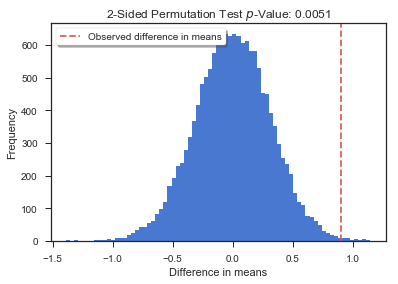

In [5]:
plt.figure()

plt.hist(pt.dist, bins="auto")
plt.axvline(res.statistic, c="r", ls="--", label="Observed difference in means")
plt.legend(loc="best", frameon=True, shadow=True)
plt.title(f"2-Sided Permutation Test $p$-Value: {res.p_value:.4f}")
plt.xlabel("Difference in means")
plt.ylabel("Frequency")
plt.show()
plt.close()

This suggests that our null hypothesis (that the true means of $X$ and $Y$ are the same) can be rejected at the $\alpha = 0.05$ significance level.
The observed difference in means is extreme relative to the empirical distribution of the mean differences of the permuted samples.